In [ ]:
! python -m pip install -q  rebound

     |████████████████████████████████| 284 kB 4.5 MB/s 


In [ ]:
! python -m pip install -q spiceypy

     |████████████████████████████████| 1.7 MB 22.9 MB/s 


In [ ]:
import rebound as rb
import numpy as np
import matplotlib.pyplot as plt
from spiceypy import vcrss,mxv,rotate
import pandas as pd
from scipy.integrate import odeint
import re

## Solucion con Rebound

In [ ]:
sim = rb.Simulation()

In [ ]:
sim.integrator = "whfast"
# sim.ri_whfast.coordinates = "democraticheliocentric"
sim.softening = 1e-10
sim.dt = 1e-6

In [ ]:
sim.N_active = 2

In [ ]:
alpha = 0.3

In [ ]:
sim.add(m = 1-alpha,x = -alpha,vy = -alpha)
sim.add(m = alpha, x = 1-alpha,vy = 1-alpha)

In [ ]:
sim.add(m = 0, x = 1,vy = 0.45+vcrss([0,0,1],[1,0,0])[1])

In [ ]:
sim.move_to_com()

In [ ]:
T = 10
N = 10000

In [ ]:
t = np.linspace(0,T,N)
Y = np.zeros((3,N,6))
for i,t_i in enumerate(t):
  sim.integrate(t_i)
  p1 = sim.particles[0]
  p2 = sim.particles[1]
  p3 = sim.particles[2]

  Y[0][i] = p1.x,p1.y,p1.z,p1.vx,p1.vy,p1.vz
  Y[1][i] = p2.x,p2.y,p2.z,p2.vx,p2.vy,p2.vz
  Y[2][i] = p3.x,p3.y,p3.z,p3.vx,p3.vy,p3.vz

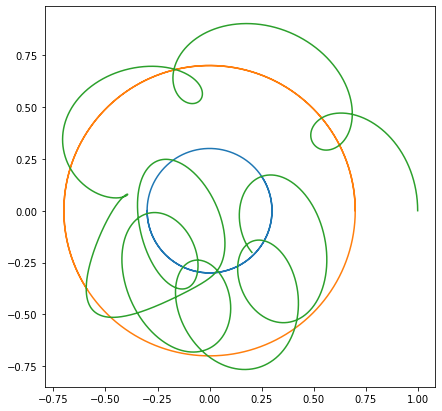

In [ ]:
plt.figure(figsize = (7,7))
plt.plot(Y[0,:,0],Y[0,:,1])
plt.plot(Y[1,:,0],Y[1,:,1])
plt.plot(Y[2,:,0],Y[2,:,1])

### Sistema rotante

In [ ]:
Yrot = np.zeros_like(Y)

In [ ]:
for i in range(N):
  MRot = rotate(t[i],3)
  for k in range(3):
    Yrot[k,i][:3]=mxv(MRot,Y[k,i,:3])
    Yrot[k,i][3:]=mxv(MRot,Y[k,i,3:]-vcrss([0,0,1],Y[k,i,:3]))

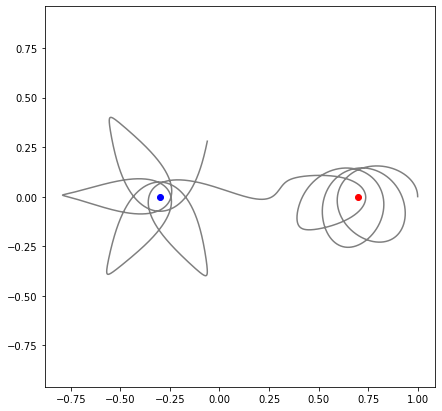

In [ ]:
plt.figure(figsize = (7,7))
plt.plot(-alpha,0,"bo")
plt.plot(1-alpha,0,"ro")
plt.plot(Yrot[2,:,0],Yrot[2,:,1],"k",alpha = 0.5)
plt.axis("equal")
plt.show()

## Funcion con Rebound

In [ ]:
def get_orbit(alpha,Y0,T,t):
    sim = rb.Simulation()
    sim.integrator = "mercurius"
    sim.softening = 1e-8
    sim.ri_mercurius.hillfac = 3.
    sim.N_active = 2

    r0 = Y0[:3]
    v0 = Y0[3:]

    sim.add(m = 1-alpha,x = -alpha,vy = -alpha)
    sim.add(m = alpha, x = 1-alpha,vy = 1-alpha)

    x,y,z = r0
    vx,vy,vz = v0 + vcrss([0,0,1],[x,0,0])
    sim.add(m = 0, x = x,y = y, z = z , vx = vx, vy = vy, vz = vz)

    sim.move_to_com()
    N = len(t)
    Y = np.zeros((3,N,6))
    Yrot = np.zeros_like(Y)
    for i,t_i in enumerate(t):
        sim.integrate(t_i)
        MRot = rotate(t_i,3)
        for k in range(3):
            p = sim.particles[k]

            Y[k,i] = p.x,p.y,p.z,p.vx,p.vy,p.vz
            Yrot[k,i][:3]=mxv(MRot,Y[k,i,:3])
            Yrot[k,i][3:]=mxv(MRot,Y[k,i,3:]-vcrss([0,0,1],Y[k,i,:3]))
    return Y,Yrot

In [ ]:
alpha = 0.3
r = np.array([1,0,0])
v = np.array([0,.45,0])
Y0 = np.concatenate([r,v])
t = np.linspace(0,10,1000)
Y,Yrot = get_orbit(0.3,Y0,10,t)

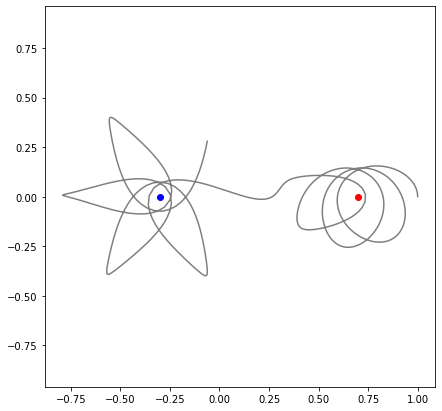

In [ ]:
plt.figure(figsize = (7,7))
plt.plot(-alpha,0,"bo")
plt.plot(1-alpha,0,"ro")
plt.plot(Yrot[2,:,0],Yrot[2,:,1],"k",alpha = 0.5)
plt.axis("equal")
plt.show()

##Base de datos

In [ ]:
data = pd.read_csv('gridPOrun.out',delim_whitespace=True, comment = "%",header = None)

In [ ]:
col = open("columnNames.output","r")
txt = col.read()
txt = re.sub(" +"," ",txt).replace("\n "," ").replace("\n","")
header = txt.split(" ")[1:-1]
data.columns = header

In [ ]:
orbit_trial = data.iloc[8]

In [ ]:
alpha = orbit_trial["massratio"]
x1 = orbit_trial["x(1)"]
x2 = orbit_trial["x(2)"]
x3 = orbit_trial["x(3)"]
x4 = orbit_trial["x(4)"]
x5 = orbit_trial["x(5)"]
x6 = orbit_trial["x(6)"]

Y0 = np.array([x1,x2,x3,x4,x5,x6])

#Se pasa al sistema COM
Y0[0] += (1-alpha)
period = orbit_trial["period"]

### Con rebound

In [ ]:
t = np.linspace(0,period,int(1e3))
Y,Yrot = get_orbit(alpha,Y0,period,t)

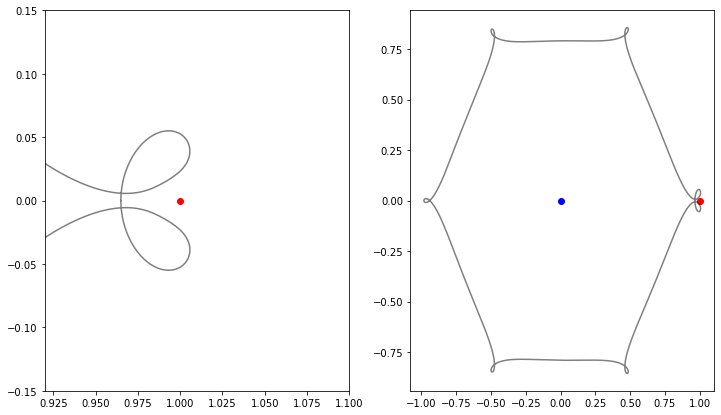

In [ ]:
plt.figure(figsize = (12,7))
plt.subplot(1,2,1)
plt.plot(-alpha,0,"bo")
plt.plot(1-alpha,0,"ro")
plt.plot(Yrot[2,:,0],Yrot[2,:,1],"k",alpha = 0.5)
plt.xlim(0.92,1.1)
plt.ylim(-0.15,0.15)
plt.subplot(1,2,2)
plt.plot(-alpha,0,"bo")
plt.plot(1-alpha,0,"ro")
plt.plot(Yrot[2,:,0],Yrot[2,:,1],"k",alpha = 0.5)
plt.show()

### Utilizando ODEINT y el potencial modificado

In [ ]:
def CRTBP(Y,t,alpha):
    x,y,z,vx,vy,vz = Y
    var1 = np.sqrt(x**2+y**2+z**2+2*x*alpha+alpha**2)
    var2 = (1-alpha)/var1**2/var1

    var3 = np.sqrt(x**2+y**2+z**2-2*x*(1-alpha)+(1-alpha)**2)
    var4 = alpha/var3**2/var3

    ax = 2*vy+x-var2*(x+alpha)-var4*(x-(1-alpha))
    ay = -2*vx+y-var2*y-var4*y
    az = -var2*z-var4*z
    return [vx,vy,vz,ax,ay,az]

In [ ]:
t = np.linspace(0,period,85064)
Y0 = np.array((x1,x2,x3,x4,x5,x6))

#Se pasa al COM
Y0[0] += (1-alpha)
Y = odeint(CRTBP,y0=Y0,t = t,args= (alpha,),atol = 1e-16,rtol =1e-13)

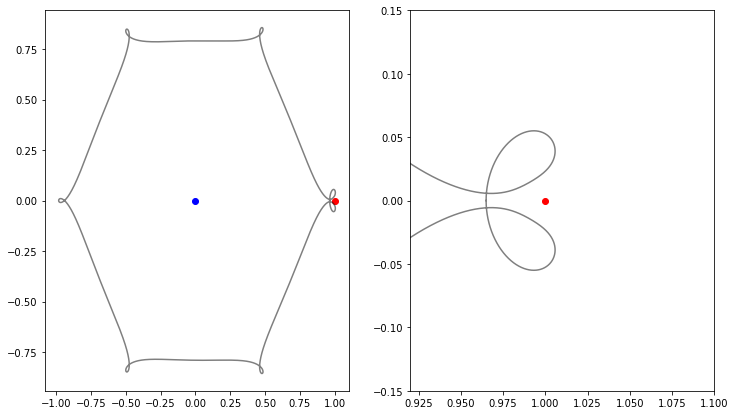

In [ ]:
plt.figure(figsize = (12,7))
plt.subplot(1,2,1)
plt.plot(-alpha,0,"bo")
plt.plot(1-alpha,0,"ro")
plt.plot(Y[:,0],Y[:,1],"k",alpha = 0.5)
plt.subplot(1,2,2)
plt.plot(-alpha,0,"bo")
plt.plot(1-alpha,0,"ro")
plt.plot(Y[:,0],Y[:,1],"k",alpha = 0.5)
plt.xlim(0.92,1.1)
plt.ylim(-0.15,0.15)
plt.show()

### Funcion para graficar con rebound u Odeint

In [ ]:
def database_orbit(file,columns,index= 0, method = "orbit",N = 1e5):
    data = pd.read_csv(file,delim_whitespace=True, comment = "%",header = None)
    col = open(columns,"r")
    txt = col.read()
    txt = re.sub(" +"," ",txt).replace("\n "," ").replace("\n","")
    header = txt.split(" ")[1:-1]
    data.columns = header
    orbit_trial = data.iloc[index]

    alpha = orbit_trial["massratio"]
    x1 = orbit_trial["x(1)"]
    x2 = orbit_trial["x(2)"]
    x3 = orbit_trial["x(3)"]
    x4 = orbit_trial["x(4)"]
    x5 = orbit_trial["x(5)"]
    x6 = orbit_trial["x(6)"]

    Y0 = np.array([x1,x2,x3,x4,x5,x6])

    #Se pasa al sistema COM
    Y0[0] += (1-alpha)
    period = orbit_trial["period"]
    t = np.linspace(0,period,int(N))

    if method != "orbit" and method != "odeint":
        raise ValueError('method should be "orbit" or "odeint"')

    if method == "orbit":
        Y,Yrot = get_orbit(alpha,Y0,period,t)
        Yrot = Yrot[2]
    else:
        #Se pasa al COM
        Yrot = odeint(CRTBP,y0=Y0,t = t,args= (alpha,),atol = 1e-16,rtol =1e-13)
    IS = {"Y0":Y0,"alpha":alpha,"P":period,"t":t}


    return Yrot,IS

In [ ]:
print(Y0)

[0.96497472 0.         0.         0.         0.07009877 0.        ]


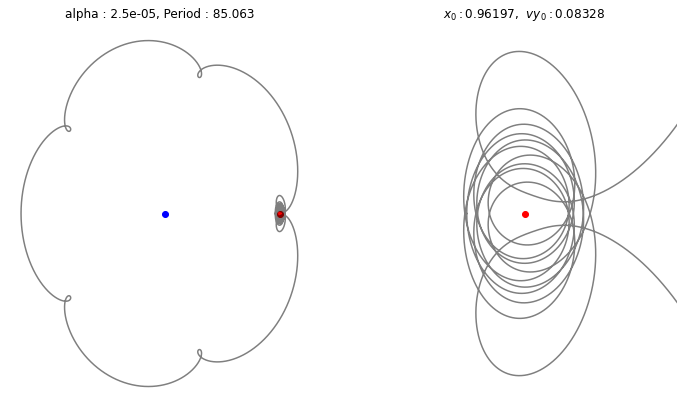

In [ ]:
Y,IS = database_orbit("gridPOrun.out","columnNames.output",index= 8, method = "odeint",N = 1e6)
alpha = IS["alpha"]
Y0 = IS["Y0"]
P = IS["P"]

plt.figure(figsize = (12,7))
plt.subplot(1,2,1)
plt.title("alpha : {}, Period : {}".format(round(alpha,6),round(P,3)))
plt.plot(-alpha,0,"bo")
plt.plot(1-alpha,0,"ro")
plt.plot(Y[:,0],Y[:,1],"k",alpha = 0.5)
plt.grid()
plt.axis("off")
plt.subplot(1,2,2)
plt.title(r"$x_0 : {}$,  $vy_0 : {}$".format(round(Y0[0],5),round(Y0[4],5)))
plt.plot(1-alpha,0,"ro")
plt.plot(Y[:,0],Y[:,1],"k",alpha = 0.5)
plt.xlim(0.9,1.1)
plt.ylim(-0.15,0.15)
plt.grid()
plt.axis("off")
plt.show()

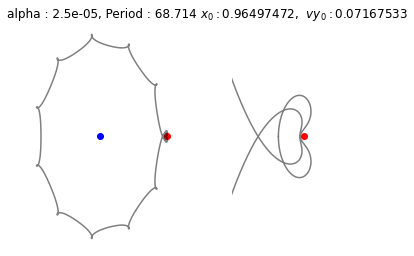

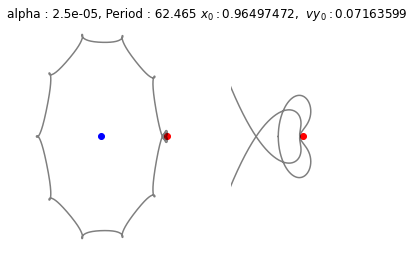

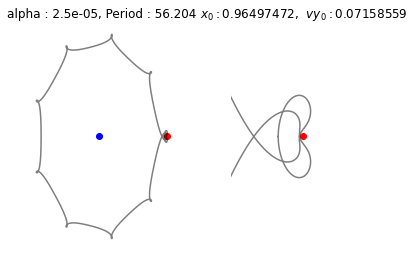

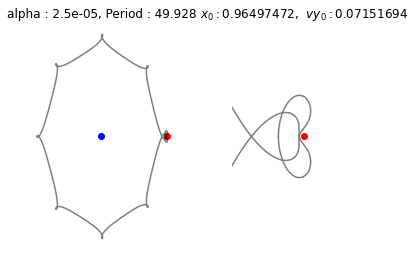

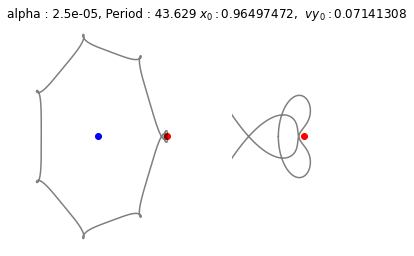

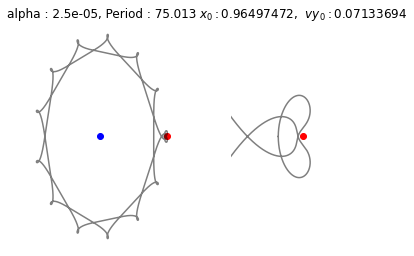

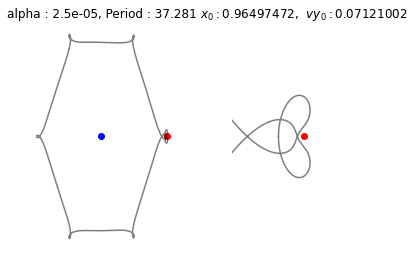

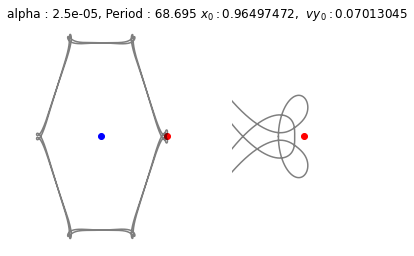

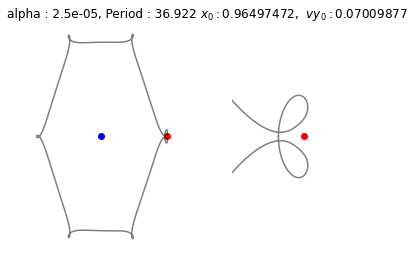

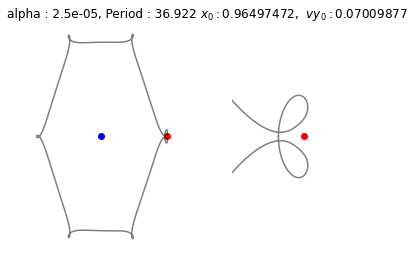

In [ ]:
for i in range(0,10):
    Y,IS = database_orbit("gridPOrun.out","columnNames.output",index= i, method = "odeint",N = 1e6)
    alpha = IS["alpha"]
    Y0 = IS["Y0"]
    P = IS["P"]
    plt.subplot(1,2,1)
    plt.title("alpha : {}, Period : {}".format(round(alpha,6),round(P,3)))
    plt.plot(-alpha,0,"bo")
    plt.plot(1-alpha,0,"ro")
    plt.plot(Y[:,0],Y[:,1],"k",alpha = 0.5)
    plt.axis("off")
    plt.subplot(1,2,2)
    plt.title(r"$x_0 : {}$,  $vy_0 : {}$".format(round(Y0[0],8),round(Y0[4],8)))
    plt.plot(1-alpha,0,"ro")
    plt.plot(Y[:,0],Y[:,1],"k",alpha = 0.5)
    plt.xlim(0.9,1.1)
    plt.ylim(-0.15,0.15)
    plt.axis("off")
    plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    wspace=0.4,
                    hspace=0.4)
    plt.show()

In [ ]:
%%time
Y1,IS1 = database_orbit("gridPOrun.out","columnNames.output",index= 3, method = "odeint",N = 1e6)

CPU times: user 811 ms, sys: 12 ms, total: 823 ms
Wall time: 1.24 s


In [ ]:
%%time
Y2,IS2 = database_orbit("gridPOrun.out","columnNames.output",index= 3, method = "orbit",N = 1e2)

CPU times: user 1.24 s, sys: 16.1 ms, total: 1.26 s
Wall time: 1.71 s


In [ ]:
def get_orbit_1(alpha,Y0,T,t):
    sim = rb.Simulation()
    sim.integrator = "mercurius"
    sim.softening = 1e-8
    sim.ri_mercurius.hillfac = 3.
    sim.N_active = 2

    r0 = Y0[:3]
    v0 = Y0[3:]

    sim.add(m = 1-alpha,x = -alpha,vy = -alpha)
    sim.add(m = alpha, x = 1-alpha,vy = 1-alpha)

    x,y,z = r0
    vx,vy,vz = v0 + vcrss([0,0,1],[x,0,0])
    sim.add(m = 0, x = x,y = y, z = z , vx = vx, vy = vy, vz = vz)

    sim.move_to_com()
    N = len(t)

    Yrot = np.zeros((N,6))

    for i,t_i in enumerate(t):

        sim.integrate(t_i)
        MRot = rotate(t_i,3)
        p = sim.particles[2]

        Y = np.array((p.x,p.y,p.z,p.vx,p.vy,p.vz))

        Yrot[i,:3] = mxv(MRot,Y[:3])
        Yrot[i,3:] = mxv(MRot,Y[3:]-vcrss([0,0,1],Y[:3]))
    return Yrot
